H 2.1 Logistic regression: Suppose we have labeled data(xi,yi), where **x**<sub>i</sub>∈Rd,y∈{0,1}. We want to compute **w** that minimizes the following negative log-likelihood function:  

$$\text{minimize}_w\sum y_{i}log(1+exp(-w^Tx_{i})) + (1-y_i)log(1+exp(w^Tx_i))$$

Let us denote the objective of this function as J(w). (Note that we could also define y_i∈{−1,1} and rewrite the objective in (1) as J(w) = $\sum log(1+exp(-y_iw^Tx_{i}))$

(a) Show the the following log-logistic function is convex:  
$$f(w) = log(1+exp(-w^Tx))$$  

You may assume that __x__ is a scalar and show that the second derivative of $f(\mathbf{w})$ w.r.t. __w__ is always positive.

$$
\begin{gather*}
\frac{\partial f(w)}{\partial w} = \frac{\partial}{\partial w} log(1 + e^{(-w^Tx)}) \\
\frac{\partial f(w)}{\partial w} = \frac{e^{(-w^Tx)}*-x}{1+e^{(-w^Tx)}} \\
\\
\frac{\partial^2 f(w)}{\partial w} = \frac{\partial}{\partial w}\frac{e^{(-w^Tx)}*-x}{1+e^{(-w^Tx)}} \\
\frac{\partial^2 f(w)}{\partial w} = -x[(x)(e^{(-w^Tx)})^2(1+e^{(-w^Tx)})^{-2} + (-x)e^{(-w^Tx)}(1+e^{-w^Tx})^{-1}] \\
\frac{\partial^2 f(w)}{\partial w} = x^2\left[-\left(\frac{e^{(-w^Tx)}}{1+e^{(-w^Tx)}}\right)^2 + \frac{e^{(-w^Tx)}}{1+e^{(-w^Tx)}}\right] \\
\frac{\partial^2 f(w)}{\partial w} = x^2\left[\frac{e^{(-w^Tx)} + e^{(-2w^Tx)} - e^{(-2w^Tx)}}{(1+e^{(-w^Tx)})^2} \right] \\
\frac{\partial^2 f(w)}{\partial w} = x^2 \left[ \frac{e^{(-w^Tx)}}{(1+e^{(-w^Tx)})^2} \right] \\
\text{Both terms are always greater than 0. Therefore, } \\
\frac{\partial^2 f(w)}{\partial w} \geq 0
\end{gather*}
$$

(b) Next you will write a Python script for logistic regression that solves (1) using gradient descent algorithm with a fixed step size α. You will then use your code to learn to classify images of digits from the MNIST dataset.  

You can show that the expression for $\nabla_w J = - \sum_{i=1}^N (y_i−h_w(x_i))x_i$, where $h(w) = \frac{1}{1+e^{(-w^Tx)}}$

In [1]:
import numpy as np
import scipy.io as sio

mnist =sio.loadmat('mnistoriginal.mat')
data=mnist['data']
label=mnist['label']
data = (data - np.mean(data,axis=0))/(np.std(data,axis=0)+0.1)

train_x = data[:,0:60000]
train_y = label[0,0:60000]
test_x = data[:,60000:70000]
test_y = label[0,60000:70000]

# Choose only two digits
class_0=0
class_1=1
idx_train=[]
for i in range (0,train_y.shape[0]):
    if (train_y[i]==class_0) or (train_y[i]==class_1):
        idx_train=np.append(idx_train,i)
        
idx_test=[]
for i in range (0,test_y.shape[0]):
    if (test_y[i]==class_0) or (test_y[i]==class_1):
        idx_test=np.append(idx_test,i)
                
train_x=np.transpose(train_x)
test_x=np.transpose(test_x)
trainx=[]
trainy=[]
testx=[]
testy=[]

for i in range(0,idx_train.shape[0]):
    trainx.append(train_x[np.int(idx_train[i]),:])
    if train_y[np.int(idx_train[i])]==class_0:
        trainy.append(0)
    else:
        trainy.append(1)
        
for i in range(0,idx_test.shape[0]):
    testx.append(test_x[np.int(idx_test[i]),:])
    if test_y[np.int(idx_test[i])]==class_0:
        testy.append(0)
    else:
        testy.append(1)
        
train_x=np.array(trainx)
train_y = np.array(trainy)
test_x = np.array(testx)
test_y = np.array(testy)

train_x = np.insert(train_x,0,1,axis=1)
test_x = np.insert(test_x,0,1,axis=1)

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
sigmoid_vec = np.vectorize(sigmoid)

In [56]:
def gradient(w, x, y):
    h = sigmoid_vec(np.matmul(x,w))
    return -(np.matmul((y - h),x))

In [61]:
def logistic_regression(w, x, y):
    a = 0.000001
    if(np.all(gradient(w,x,y) < 0)):
        return logistic_regression(w - a*gradient(w,x,y),x,y)
    else:
        return w - a*gradient(w,x,y)

In [62]:
w = logistic_regression(np.ones(train_x.shape[1]),train_x, train_y)
#np.matmul(train_x, np.zeros(train_x.shape[1])).shape
predict = np.round(sigmoid_vec(np.matmul(test_x.astype(float),w)))
acc =100.0*np.sum(test_y == predict)/test_y.shape[0]
print(acc)

96.6903073286052


H 2.2 Perceptron learning algorithm (PLA) and kernel extension: In this problem you will implement PLA to build a simple binary classification system. Suppose we have labeled data $(\mathbf{x}_i, y_i)$, where $\mathbf{x}_i ∈ R^{d+1}$ with $\mathbf{x}_i(1) = 1$ and y ∈ {-1, +1}. Let us define $h_{\mathbf{w}}(\mathbf{x}_i) = sign(\mathbf{w}^T\mathbf{x}_i)$. We want to computer **w** using PLA.  <br><br>
(a) Data Processing: Generate two examples of 2D *linearly separable* dataset with N = 100 samples each. (To do this, you will first generate a weight vector and constant term,w, and then assign ±1 labels to your data samples as $y_i=h_{\mathbf{w}}(\mathbf{x}_i)$.) Let us call the two datasets “Data1” and“Data2”. For Data1, randomly select 80% of the samples for training and the remaining 20% for testing on Data1 (80/20). For Data2, randomly select 30% of the samples for training and the remaining 70% for testing (30/70).

In [233]:
N = 100
w = np.random.rand(2)

data1 = np.random.randn(N,2)
data2 = np.random.randn(N,2)

def h(x,w):
    return np.sign(np.matmul(x,w))

y1 = h(data1,w)
y2 = h(data2,w)

idx1 = np.random.choice(100, 100,replace=False)
data1_train = data1[idx1[:80]]
y1_train = y1[idx1[:80]]
data1_test = data1[idx1[81:]]
y1_test = y1[idx1[81:]]

idx2 = np.random.choice(100,100, replace=False)
data2_train = data2[idx2[:30]]
y2_train = y2[idx2[:30]]
data2_test = data2[idx2[31:]]
y2_test = y2[idx2[31:]]

In [102]:
def PLA(x, y):
    w = np.zeros(2)
    N = x.shape[0]
    for i in np.arange(0,N-1):
        w = w+1/2*(y[i] - h(x[i,:],w))*x[i,:]
    return w

In [261]:
w1 = PLA(data1_train, y1_train)
w2 = PLA(data2_train, y2_train)
print('w1 = ', w1, ', w2 = ', w2)

w1 =  [0.53509473 1.70086547] , w2 =  [0.17237797 1.26538595]


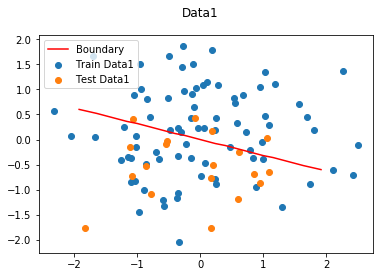

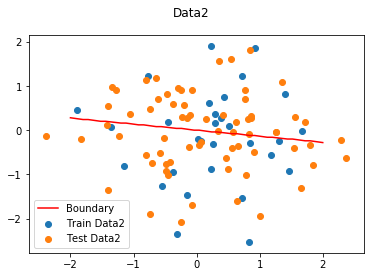

In [235]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.scatter(data1_train[:,0], data1_train[:,1], label='Train Data1')
ax1.scatter(data1_test[:,0], data1_test[:,1], label='Test Data1')
H = []
for x1 in np.linspace(-2,2, 101):
    for x2 in np.linspace(-2,2, 101):
        if(abs(np.matmul([x1,x2],w1)) < 0.01):
            H.append([x1, x2])
            break
ax1.plot(np.array(H)[:,0],np.array(H)[:,1], label='Boundary', c='red')
ax1.legend()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(data2_train[:,0], data2_train[:,1], label='Train Data2')
ax2.scatter(data2_test[:,0], data2_test[:,1], label='Test Data2')
H = []
for x1 in np.linspace(-2,2, 101):
    for x2 in np.linspace(-2,2, 101):
        if(abs(np.matmul([x1,x2],w2)) < 0.01):
            H.append([x1, x2])
            break
ax2.plot(np.array(H)[:,0],np.array(H)[:,1], label='Boundary', c='red')
ax2.legend()
fig1.suptitle('Data1')
fig2.suptitle('Data2')
plt.show()

In [236]:
y_test1 = h(data1_test, w1)
tp1 = np.sum(y_test1 == y1_test)
fp1 = np.sum(np.logical_and((y_test1 == 1),(y1_test == -1)))
fn1 = np.sum(np.logical_and((y_test1 == -1), (y1_test == 1)))
percision1 = tp1/(tp1+fp1)
recall1 = tp1/(tp1+fn1)
f11 = 2*(percision1*recall1)/(percision1+recall1)

y_test2 = h(data2_test,w2)
tp2 = np.sum(y_test2 == y2_test)
fp2 = np.sum(np.logical_and((y_test2 == 1), (y2_test == -1)))
fn2 = np.sum(np.logical_and((y_test2 == -1), (y2_test == 1)))
percision2 = tp2/(tp2+fp2)
recall2 = tp2/(tp2+fn2)
f12 = 2*(percision2*recall2)/(percision2+recall2)

print('f1 score for Data1: ', f11)
print('f1 score for Data2: ', f12)

f1 score for Data1:  1.0
f1 score for Data2:  0.9777777777777777


In [259]:
a = np.zeros(N)
for j in np.arange(0, N-1):
    Y = np.sign(np.sum((a*y1)*np.matmul(data1[0,:],np.transpose(data1[0,:]))))
    if(not(Y==y1[j])):
        a[j] = a[j] + 1

w = 0
for i in range(N):
    w = w+a[i]*y1[i]*data1[i,:]

[-105.34430407012508,
 -105.16825359590044,
 -104.99220312167579,
 -104.81615264745115,
 -104.6401021732265,
 -104.46405169900186,
 -104.28800122477722,
 -104.11195075055257,
 -103.93590027632793,
 -103.75984980210328,
 -103.58379932787864,
 -103.407748853654,
 -103.23169837942935,
 -103.05564790520471,
 -102.87959743098006,
 -102.70354695675542,
 -102.52749648253076,
 -102.35144600830613,
 -102.17539553408149,
 -101.99934505985684,
 -101.8232945856322,
 -101.64724411140755,
 -101.4711936371829,
 -101.29514316295827,
 -101.11909268873362,
 -100.94304221450898,
 -100.76699174028433,
 -100.59094126605969,
 -100.41489079183505,
 -100.2388403176104,
 -100.06278984338576,
 -99.8867393691611,
 -99.71068889493647,
 -99.53463842071183,
 -99.35858794648718,
 -99.18253747226254,
 -99.00648699803789,
 -98.83043652381326,
 -98.65438604958861,
 -98.47833557536397,
 -98.30228510113932,
 -98.12623462691468,
 -97.95018415269004,
 -97.77413367846539,
 -97.59808320424075,
 -97.4220327300161,
 -97.245982

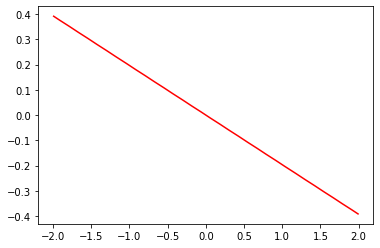

In [266]:
fig = plt.figure()
ax = fig.add_subplot(111)
H = []
G = []
for x1 in np.linspace(-2,2, 1001):
    for x2 in np.linspace(-2,2, 1001):
        G.append(np.matmul([x1,x2],w))
        if(abs(np.matmul([x1,x2],w)) < 0.01):
            H.append([x1, x2])
            break
ax.plot(np.array(H)[:,0],np.array(H)[:,1], label='Boundary', c='red')
G